# Algorithm principle

HR = high resolution
<br> LR = low resolution

The problem (ill-posed) is the following : we want to estimate the voxels of the HR image from the pixels of the low resolution image. To make it simpler, we can model the LR data as an average of the surrounding HR pixels :
$$y_j = \frac{1}{N} \sum_{i=1}^{N} x_i + n \text{,  where n is the Rician noise}$$
The idea would then be to estimate the $x_i$ from the $y_j$. We notice that there will be infinite values that will meet this condition. So we could first add a regularization term to limit the number of solutions, but regularization is known for destroying the high frequency content of the results, which is what we'd like to obtain.
#### Here comes the example-based method :
- Ideas : 1) Apply some filter to minimize the noise present in the LR data.
<br> 2) Reconstructed the image by applying high weights to voxels similar with the ones in the HR reference data, and to voxels with similar neighborhoods in the currently reconstructed data (reduces mis-alignements).
<br> 3) Subsampling consistency : impose the downsampled version of the reconstructed data to be the same as the original LR data
- Data required : HR reference data, preinterpolated LR data
- Iteratively update the reconstructed image voxels using the following idea : similar voxels in the HR tend to be similar in the reconstructed data, so averaging these with weights reflecting similar intensity in HR data and similar local context in LR data should help converging to a high frequency image, well aligned with the original LR image. Then, correct the voxels values so that they fit with the original LR data

#### The steps to follow are the following :
- Interpolate the LR data in order to get the same number of voxels than the HR reference : 
https://docs.scipy.org/doc/scipy/reference/generated/scipy.misc.imresize.html / 
http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize
- Denoise the LR data to reconstruct (and the reference HR data for voxel similarity computations) : (BNLM3D filter optimal) we'll use standard NL means version because seems to perform OK  http://nipy.org/dipy/examples_built/denoise_nlmeans.html
- Iterate till the mean_absolute_error of the reconstructed data gets inferior to some tolerance :
<br, > 1) Reconstruction
<br, > 2) Mean correction : Nearest Neighbor interpolation (of the diff between the reconstructed data downsampled and the original LR data) withdrawn from the new reconstructed data.

#### Computations :
- filtering step : use symmetric weights

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.measure import block_reduce
from dipy.denoise.nlmeans import nlmeans
from dipy.denoise.noise_estimate import estimate_sigma
import time
%matplotlib inline

In [2]:
os.chdir('code_scripts')
import visualization as viz
os.chdir('../')

# Preprocessing : creating LR images and denoising (Rician noise)

In [3]:
data_path = 'HR_data/'

HR_ref = np.load(data_path+'image1.npy')
HR_ref.shape

(444, 448, 38)

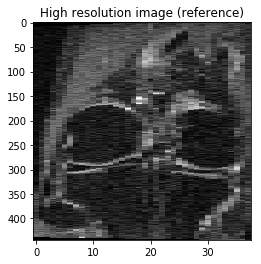

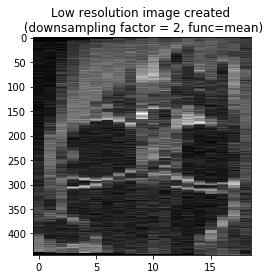

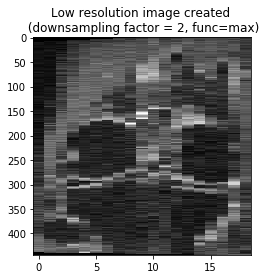

[func=max] seems slightly better


In [4]:
plt.title('High resolution image (reference)')
viz.visualize_MRI_slice(HR_ref, 280, slice_direction=1)

plt.title('Low resolution image created \n (downsampling factor = 2, func=mean)')
LR_img = block_reduce(HR_ref, block_size=(1,1,2), func=np.mean)
viz.visualize_MRI_slice(LR_img, 280, slice_direction=1)

plt.title('Low resolution image created \n (downsampling factor = 2, func=max)')
LR_img = block_reduce(HR_ref, block_size=(1,1,2), func=np.max)
viz.visualize_MRI_slice(LR_img, 280, slice_direction=1)

print('[func=max] seems slightly better')

#### Denoising the LR image (Rician noise) - (HR should be denoised also, but need to be careful that it doesn't screw the HR content)

In [5]:
sigma_esti = estimate_sigma(LR_img, N=1)
LR_denoised = nlmeans(LR_img, sigma=sigma_esti, patch_radius= 1, block_radius = 1, rician= True)

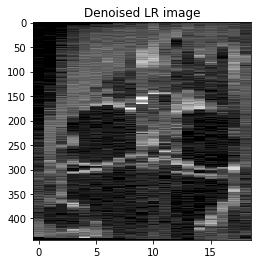

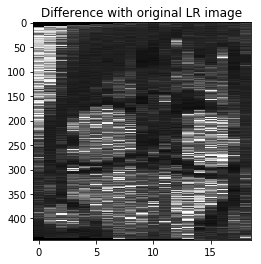

In [6]:
plt.title('Denoised LR image')
viz.visualize_MRI_slice(LR_denoised, 280, slice_direction=1)
plt.title('Difference with original LR image')
viz.visualize_MRI_slice(LR_img-LR_denoised, 280, slice_direction=1)

#### Looking at the effects of denoising on the HR image (if no enhancement we shouldn't do it)
I think it enhances the results, and doesn't destroy the image structure

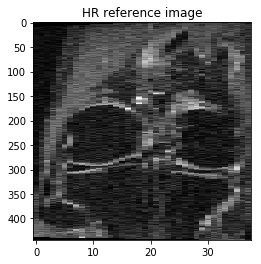

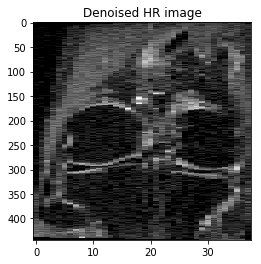

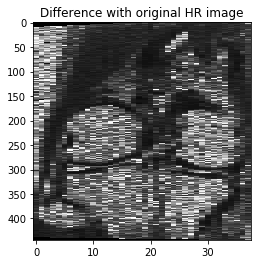

In [7]:
sigma_esti = estimate_sigma(HR_ref, N=1)
HR_denoised = nlmeans(HR_ref, sigma=sigma_esti, patch_radius= 1, block_radius = 1, rician= True)

plt.title('HR reference image')
viz.visualize_MRI_slice(HR_ref, 280, slice_direction=1)
plt.title('Denoised HR image')
viz.visualize_MRI_slice(HR_denoised, 280, slice_direction=1)
plt.title('Difference with original HR image')
viz.visualize_MRI_slice(HR_ref-HR_denoised, 280, slice_direction=1)

## Pre-interpolation (or blurring of HR image)

#### EITHER : create a LR image from a HR one by blurring it, and use it directly for computations.
Blurring doesn't work for unknown reasons (maybe beacause it's 3D and resolution isn't the same over the diff directions, so when you take the mean on a same sized neighborhood along every directions it screws the results)

In [8]:
"""
LR_img = None

kernel = -1./26 * np.ones([3,3,3])
kernel[1,1,1] = 1

def blurring_HR(HR_ref, kernel):
    LR_img = np.copy(HR_ref)
    m,n,p = LR_img.shape[0], LR_img.shape[1], LR_img.shape[2]
    LR_img[1:(m-1), 1:(n-1), 1:(p-1)] = np.zeros([m-2,n-2,p-2])
    for i in range(1,m-1):
        for j in range(1,n-1):
            for k in range(1,p-1):
                LR_img[i,j,k] = np.sum(kernel*HR_ref[(i-1):(i+2),(j-1):(j+2),(k-1):(k+2)])
    return LR_img

LR_img = blurring_HR(HR_ref)
"""

'\nLR_img = None\n\nkernel = -1./26 * np.ones([3,3,3])\nkernel[1,1,1] = 1\n\ndef blurring_HR(HR_ref, kernel):\n    LR_img = np.copy(HR_ref)\n    m,n,p = LR_img.shape[0], LR_img.shape[1], LR_img.shape[2]\n    LR_img[1:(m-1), 1:(n-1), 1:(p-1)] = np.zeros([m-2,n-2,p-2])\n    for i in range(1,m-1):\n        for j in range(1,n-1):\n            for k in range(1,p-1):\n                LR_img[i,j,k] = np.sum(kernel*HR_ref[(i-1):(i+2),(j-1):(j+2),(k-1):(k+2)])\n    return LR_img\n\nLR_img = blurring_HR(HR_ref)\n'

In [9]:
"""
viz.visualize_MRI_slice(LR_img, 280, slice_direction=1)
"""

'\nviz.visualize_MRI_slice(LR_img, 280, slice_direction=1)\n'

#### OR : interpolate the LR image to resize it as the HR one, then it can be used for computations

In [10]:
#from scipy.interpolate import NearestNDInterpolator, Rbf : other possib to explore

LR_img_interp = resize(LR_denoised, output_shape=HR_ref.shape, mode='symmetric', order=3)

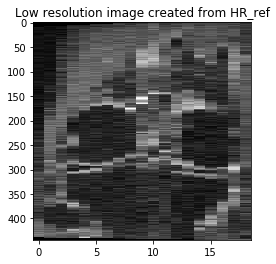

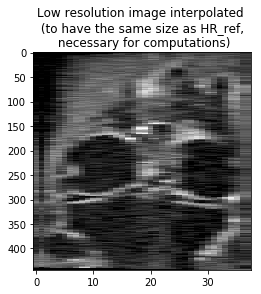

In [11]:
plt.title('Low resolution image created from HR_ref')
viz.visualize_MRI_slice(LR_img, 280, slice_direction=1)

plt.title('Low resolution image interpolated \n (to have the same size as HR_ref, \n necessary for computations)')
viz.visualize_MRI_slice(LR_img_interp, 280, slice_direction=1)

# Algorithm Implementation

In [12]:
def example_based_algo(HR_data, LR_data, reconstructed_data, search_radius, local_LR_radius, h_values, param_k):
    for step_nb,h in enumerate(h_values):
        print('Step '+str(step_nb)+' begun')
        temp_data = reconstructed_data.copy()
        avoid_edges = search_radius+local_LR_radius
        for i in range(avoid_edges, HR_data.shape[0]-avoid_edges):
            print('Small step '+str(i))
            for j in range(avoid_edges, HR_data.shape[1]-avoid_edges):
                for k in range(avoid_edges, HR_data.shape[2]-avoid_edges):

                    reconstructed_data[i,j,k] = calc_local_update(i,j,k, temp_data, HR_data, search_radius, 
                                                                  local_LR_radius, h, param_k)
        reconstructed_data = mean_correction(reconstructed_data, LR_data)
        
    return reconstructed_data

                
# Updating with local similarities in HR_ref + in LR data             
def calc_local_update(i,j,k, temp_data, HR_data, search_radius, local_LR_radius, h, param_k):            
    p = local_LR_radius
    update, norm_factor = 0, 0
    
    for x in range(i-search_radius, i+search_radius+1):
        for y in range(j-search_radius, j+search_radius+1):
            for z in range(k-search_radius, k+search_radius+1):
                # calc similarity in ref
                weight_1 = np.exp(-pow(HR_data[i,j,k]-HR_data[x,y,z],2)/pow(h,2))
                # calc local similarity in reconstructed_data
                weight_2 = np.exp(-np.sum((temp_data[(i-p):(i+p+1),(j-p):(j+p+1),(k-p):(k+p+1)]
                                           -temp_data[(x-p):(x+p+1),(y-p):(y+p+1),(z-p):(z+p+1)])**2) 
                                  /(param_k*pow(h,2)))
                
                norm_factor += weight_1*weight_2                
                update += temp_data[x,y,z]*weight_1*weight_2
                
    return update/norm_factor


# Downsampled version of reconstructed data = LR_data
def mean_correction(reconstructed_data, LR_data):
    
    # calc downsample version of reconstructed data && interp of diff with original LR_data
    downsampled_version = block_reduce(reconstructed_data, block_size=(1,1,2), func=np.max)
    diff_interp = resize(downsampled_version - LR_data, output_shape=reconstructed_data.shape, 
                         mode='symmetric', order=3)
    
    return reconstructed_data - diff_interp

In [31]:
params_algo = {
    'HR_data' : HR_denoised,
    'LR_data': LR_img,
    'reconstructed_data' : LR_img_interp.copy(),
    'search_radius' : 3,             # 7*7*7 search volume, to compute similarity with HR_ref
    'local_LR_radius' : 1,          # 3*3*3 local search volume for local similarity in LR)
    'h_values' : [32, 16, 8, 4, 2],
    'param_k' : 256
}

In [ ]:
reconstructed_img = example_based_algo(**params_algo)

Step 0 begun
Small step 4


/Users/victordemurat/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in ushort_scalars


Small step 5
Small step 6
Small step 7
Small step 8
Small step 9
Small step 10
Small step 11
Small step 12
Small step 13
Small step 14
Small step 15
Small step 16
Small step 17
Small step 18
Small step 19
Small step 20
Small step 21
Small step 22
Small step 23
Small step 24
Small step 25
Small step 26
Small step 27
Small step 28
Small step 29
Small step 30
Small step 31
Small step 32
Small step 33
Small step 34
Small step 35
Small step 36
Small step 37
Small step 38
Small step 39
Small step 40
Small step 41
Small step 42
Small step 43
Small step 44
Small step 45
Small step 46
Small step 47
Small step 48
Small step 49
Small step 50
Small step 51
Small step 52
Small step 53
Small step 54
Small step 55
Small step 56
Small step 57
Small step 58
Small step 59
Small step 60
Small step 61
Small step 62
Small step 63
Small step 64
Small step 65
Small step 66
Small step 67
Small step 68
Small step 69
Small step 70
Small step 71
Small step 72
Small step 73
Small step 74
Small step 75
Small step 

In [ ]:
viz.visualize_MRI_slice(reconstructed_img, 280, slice_direction=1)

# Evaluation

In [3]:
data_path = 'HR_data/'

HR_ref = np.load(data_path+'image1.npy')
LR_img = block_reduce(HR_ref, block_size=(1,1,2), func=np.max)
sigma_esti = estimate_sigma(LR_img, N=1)
LR_denoised = nlmeans(LR_img, sigma=sigma_esti, patch_radius= 1, block_radius = 1, rician= True)
LR_img_interp = resize(LR_denoised, output_shape=HR_ref.shape, mode='symmetric', order=3)

res_path = 'Results/'
result_img = np.load(res_path+'reconstructed_img.npy')

In [8]:
from skimage import exposure


def improvements_visualization(HR_ref, result_img, LR_img_interp, slice_dir, slice_index):
    
    scale = (np.min(HR_ref), np.max(HR_ref))
    big_fig = plt.figure(1, figsize=(15,5))
    
    fig = plt.subplot(131)
    fig.set_title('High resolution image (reference)')
    fig = viz.visualize_MRI_slice(HR_ref, slice_index, slice_direction=slice_dir)
    fig = plt.subplot(132)
    fig.set_title('Reconstructed image')
    fig = viz.visualize_MRI_slice(exposure.rescale_intensity(result_img, scale), 
                                  slice_index, slice_direction=slice_dir)
    fig = plt.subplot(133)
    fig.set_title('LR image \n (algo init : denoised & interpolated)')
    fig = viz.visualize_MRI_slice(exposure.rescale_intensity(LR_img_interp, scale), 
                                  slice_index, slice_direction=slice_dir)

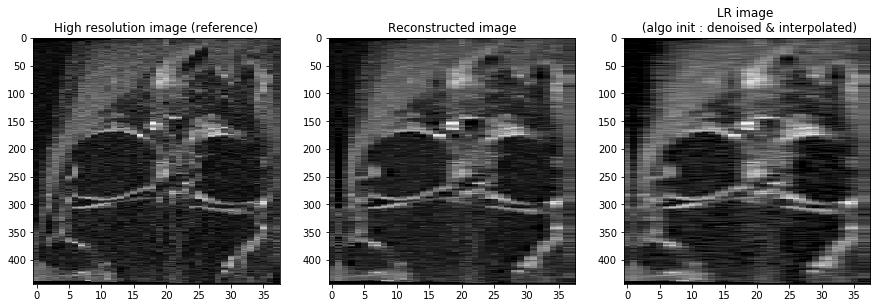

In [9]:
improvements_visualization(HR_ref, result_img, LR_img_interp, 1, 280)

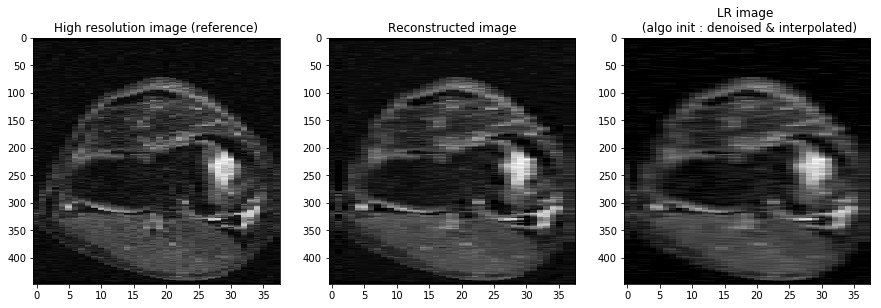

In [15]:
improvements_visualization(HR_ref, result_img, LR_img_interp, 0, 310)

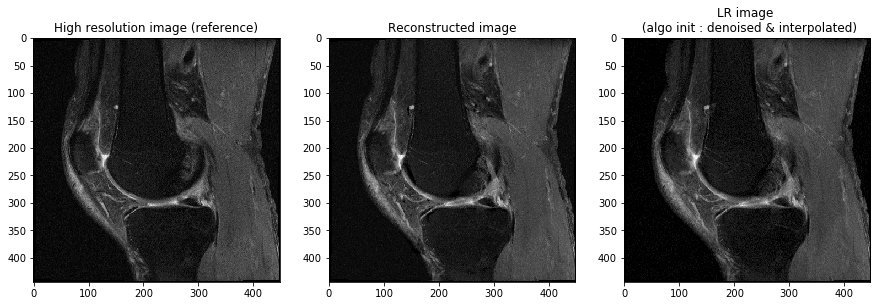

In [17]:
improvements_visualization(HR_ref, result_img, LR_img_interp, 2, 25)